# Introduction
The author follows the CRISP-DM methodology.
![CRISP-DM](Data/crisp.png)

# Business Understanding

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Data Understanding

application_{train|test}.csv

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

bureau.csv

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

POS_CASH_balance.csv

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

credit_card_balance.csv

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

previous_application.csv

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

installments_payments.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

HomeCredit_columns_description.csv

- This file contains descriptions for the columns in the various data files.

![CRISP-DM](Data/home_credit.png)

Start Spark

In [1]:
import pandas as pd
import findspark 
import os
from pyspark import SparkContext 
from pyspark.sql import SparkSession
findspark.init() 
spark = SparkSession\
    .builder\
    .appName("HomeCreditApp")\
    .config("spark.driver.memory", "8G")\
    .config("spark.executor.memory", "4G")\
    .getOrCreate()

In [2]:
sparkApplicationData = spark\
            .read\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .option("delimiter", ",")\
            .csv("Data/application_train.csv")\
            .cache()

In [3]:
sparkApplicationDataTest = spark\
            .read\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .option("delimiter", ",")\
            .csv("Data/application_test.csv")\
            .cache()

In [4]:
sparkPosCashData = spark\
            .read\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .option("delimiter", ",")\
            .csv("Data/POS_CASH_balance.csv")\
            .cache()
sparkPosCashData1 = sparkPosCashData.withColumnRenamed("SK_ID_CURR","SK_ID_CURR_MIN")
sparkPosCashData2 = sparkPosCashData.withColumnRenamed("SK_ID_CURR","SK_ID_CURR_MAX")
sparkPosCashDataMin = sparkPosCashData1.groupBy('SK_ID_CURR_MIN').min()
sparkPosCashDataMax = sparkPosCashData2.groupBy('SK_ID_CURR_MAX').max()

In [5]:
sparkBureauData = spark\
            .read\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .option("delimiter", ",")\
            .csv("Data/bureau.csv")\
            .cache()
sparkBureauData1 = sparkBureauData.withColumnRenamed("SK_ID_CURR","SK_ID_CURR_BUR_MIN")
sparkBureauData2 = sparkBureauData.withColumnRenamed("SK_ID_CURR","SK_ID_CURR_BUR_MAX")
sparkBureauDataMin = sparkBureauData1.groupBy('SK_ID_CURR_BUR_MIN').min()
sparkBureauDataMax = sparkBureauData2.groupBy('SK_ID_CURR_BUR_MAX').max()

Join tables

In [6]:
sparkApplicationData = sparkApplicationData.join(sparkPosCashDataMin, sparkApplicationData.SK_ID_CURR == sparkPosCashDataMin.SK_ID_CURR_MIN, how='left')
sparkApplicationData = sparkApplicationData.join(sparkPosCashDataMax, sparkApplicationData.SK_ID_CURR == sparkPosCashDataMax.SK_ID_CURR_MAX, how='left')
sparkApplicationData = sparkApplicationData.join(sparkBureauDataMin, sparkApplicationData.SK_ID_CURR == sparkBureauDataMin.SK_ID_CURR_BUR_MIN, how='left')
sparkApplicationData = sparkApplicationData.join(sparkBureauDataMax, sparkApplicationData.SK_ID_CURR == sparkBureauDataMax.SK_ID_CURR_BUR_MAX, how='left')

In [7]:
sparkApplicationDataTest = sparkApplicationDataTest.join(sparkPosCashDataMin, sparkApplicationDataTest.SK_ID_CURR == sparkPosCashDataMin.SK_ID_CURR_MIN, how='left')
sparkApplicationDataTest = sparkApplicationDataTest.join(sparkPosCashDataMax, sparkApplicationDataTest.SK_ID_CURR == sparkPosCashDataMax.SK_ID_CURR_MAX, how='left')
sparkApplicationDataTest = sparkApplicationDataTest.join(sparkBureauDataMin, sparkApplicationDataTest.SK_ID_CURR == sparkBureauDataMin.SK_ID_CURR_BUR_MIN, how='left')
sparkApplicationDataTest = sparkApplicationDataTest.join(sparkBureauDataMax, sparkApplicationDataTest.SK_ID_CURR == sparkBureauDataMax.SK_ID_CURR_BUR_MAX, how='left')

Columns and null values

In [8]:
sparkApplicationData\
  .printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [9]:
from pyspark.sql.functions import isnull
from IPython.core.display import HTML
for c in sparkApplicationData.columns:
  nullCnt = sparkApplicationData.where(isnull(c)).count()
  display(HTML('Column <b>{}</b> has <b>{}</b> null records'.format(str(c), nullCnt))) 

In [10]:
def displayPandas(sparkData):
    display(
    sparkData
      .limit(5)
      .toPandas()
    )

First 5 rows.

In [11]:
displayPandas(sparkApplicationData)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,max(DAYS_CREDIT_ENDDATE),max(DAYS_ENDDATE_FACT),max(AMT_CREDIT_MAX_OVERDUE),max(CNT_CREDIT_PROLONG),max(AMT_CREDIT_SUM),max(AMT_CREDIT_SUM_DEBT),max(AMT_CREDIT_SUM_LIMIT),max(AMT_CREDIT_SUM_OVERDUE),max(DAYS_CREDIT_UPDATE),max(AMT_ANNUITY)
0,351232,0,Cash loans,F,N,N,0,180000.0,495000.0,25146.0,...,333.0,NaN,0.0,0,450000.0,153814.455,0.0,0.0,-30,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1216.0,-540.0,0.0,0,810000.0,0.000,810000.0,0.0,-43,NaN
2,351234,0,Cash loans,F,N,Y,1,90000.0,107820.0,7798.5,...,1612.0,-195.0,NaN,0,882900.0,830155.500,0.0,0.0,-10,NaN
3,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-783.0,-783.0,0.0,0,146250.0,0.000,0.0,0.0,-783,NaN
4,373969,0,Cash loans,M,N,Y,0,202500.0,463284.0,22662.0,...,10151.0,-197.0,30798.0,0,1165500.0,121221.000,0.0,0.0,-29,29907.0


Number of rows

In [12]:
print(sparkApplicationData.count())

307511


# Data Preparation

Null values replaced with average value.

In [13]:
## filter numeric cols
num_cols = [col_type[0] for col_type in filter(lambda dtype: dtype[1] in {"bigint", "double", "int"}, sparkApplicationData.dtypes)]
### Compute a dict with <col_name, median_value>
median_dict = dict()
for c in num_cols:
   median_dict[c] = sparkApplicationData.stat.approxQuantile(c, [0.5], 0.001)[0]

In [14]:
sparkApplicationData = sparkApplicationData.na.fill(median_dict)

In [15]:
sparkApplicationData.write\
        .format("com.databricks.spark.csv")\
        .option("header", "true")\
        .mode("overwrite")\
        .save('Data/preparedTrain.csv')\

# Modeling

Data is transfered to H20

In [16]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/nn/9m2w7tv942d9z8drr7__jjk40000gp/T/tmpwm99icmy
  JVM stdout: /var/folders/nn/9m2w7tv942d9z8drr7__jjk40000gp/T/tmpwm99icmy/h2o_lukas_sykora_started_from_python.out
  JVM stderr: /var/folders/nn/9m2w7tv942d9z8drr7__jjk40000gp/T/tmpwm99icmy/h2o_lukas_sykora_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Prague
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"2 years, 1 month and 20 days !!!"
H2O cluster name:,H2O_from_python_lukas_sykora_ciaqhv
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [17]:
df_train = h2o.import_file('Data/preparedTrain.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
df_train.describe()

Rows:307511
Cols:168




,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR_MIN,min(SK_ID_PREV),min(SK_ID_CURR_MIN),min(MONTHS_BALANCE),min(CNT_INSTALMENT),min(CNT_INSTALMENT_FUTURE),min(SK_DPD),min(SK_DPD_DEF),SK_ID_CURR_MAX,max(SK_ID_PREV),max(SK_ID_CURR_MAX),max(MONTHS_BALANCE),max(CNT_INSTALMENT),max(CNT_INSTALMENT_FUTURE),max(SK_DPD),max(SK_DPD_DEF),SK_ID_CURR_BUR_MIN,min(SK_ID_CURR_BUR_MIN),min(SK_ID_BUREAU),min(DAYS_CREDIT),min(CREDIT_DAY_OVERDUE),min(DAYS_CREDIT_ENDDATE),min(DAYS_ENDDATE_FACT),min(AMT_CREDIT_MAX_OVERDUE),min(CNT_CREDIT_PROLONG),min(AMT_CREDIT_SUM),min(AMT_CREDIT_SUM_DEBT),min(AMT_CREDIT_SUM_LIMIT),min(AMT_CREDIT_SUM_OVERDUE),min(DAYS_CREDIT_UPDATE),min(AMT_ANNUITY),SK_ID_CURR_BUR_MAX,max(SK_ID_CURR_BUR_MAX),max(SK_ID_BUREAU),max(DAYS_CREDIT),max(CREDIT_DAY_OVERDUE),max(DAYS_CREDIT_ENDDATE),max(DAYS_ENDDATE_FACT),max(AMT_CREDIT_MAX_OVERDUE),max(CNT_CREDIT_PROLONG),max(AMT_CREDIT_SUM),max(AMT_CREDIT_SUM_DEBT),max(AMT_CREDIT_SUM_LIMIT),max(AMT_CREDIT_SUM_OVERDUE),max(DAYS_CREDIT_UPDATE),max(AMT_ANNUITY)
type,int,int,enum,enum,enum,enum,int,real,real,real,real,enum,enum,enum,enum,enum,real,int,int,real,int,int,int,int,int,int,int,int,enum,int,int,int,enum,int,int,int,int,int,int,int,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum,enum,real,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,real,int,real,real,real,real,int,real,int,int,int,int,int,int,int,real,int,real,real,real,real,int,real
mins,100002.0,0.0,,,,,0.0,25650.0,45000.0,1615.5,40500.0,,,,,,0.0

In [19]:
df_train.head()

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR_MIN,min(SK_ID_PREV),min(SK_ID_CURR_MIN),min(MONTHS_BALANCE),min(CNT_INSTALMENT),min(CNT_INSTALMENT_FUTURE),min(SK_DPD),min(SK_DPD_DEF),SK_ID_CURR_MAX,max(SK_ID_PREV),max(SK_ID_CURR_MAX),max(MONTHS_BALANCE),max(CNT_INSTALMENT),max(CNT_INSTALMENT_FUTURE),max(SK_DPD),max(SK_DPD_DEF),SK_ID_CURR_BUR_MIN,min(SK_ID_CURR_BUR_MIN),min(SK_ID_BUREAU),min(DAYS_CREDIT),min(CREDIT_DAY_OVERDUE),min(DAYS_CREDIT_ENDDATE),min(DAYS_ENDDATE_FACT),min(AMT_CREDIT_MAX_OVERDUE),min(CNT_CREDIT_PROLONG),min(AMT_CREDIT_SUM),min(AMT_CREDIT_SUM_DEBT),min(AMT_CREDIT_SUM_LIMIT),min(AMT_CREDIT_SUM_OVERDUE),min(DAYS_CREDIT_UPDATE),min(AMT_ANNUITY),SK_ID_CURR_BUR_MAX,max(SK_ID_CURR_BUR_MAX),max(SK_ID_BUREAU),max(DAYS_CREDIT),max(CREDIT_DAY_OVERDUE),max(DAYS_CREDIT_ENDDATE),max(DAYS_ENDDATE_FACT),max(AMT_CREDIT_MAX_OVERDUE),max(CNT_CREDIT_PROLONG),max(AMT_CREDIT_SUM),max(AMT_CREDIT_SUM_DEBT),max(AMT_CREDIT_SUM_LIMIT),max(AMT_CREDIT_SUM_OVERDUE),max(DAYS_CREDIT_UPDATE),max(AMT_ANNUITY)
100086,0,Cash loans,F,N,Y,1,135000,675000,21775.5,675000,Unaccompanied,Commercial associate,Higher education,Widow,House / apartment,0.019101,-14264,-2492,-4327,-4517,9,1,1,0,1,0,0,Laborers,2,2,2,THURSDAY,12,0,0,0,0,0,0,Self-employed,0.507542,0.569873,0.19862,0.0876,0.0764,0.9821,0.7552,0.0212,0,0.1379,0.1667,0.2083,0.0482,0.0756,0.0746,0,0.0036,0.084,0.0748,0.9816,0.7648,0.0191,0,0.1379,0.1667,0.2083,0.046,0.0771,0.0732,0,0.0012,0.0874,0.076,0.9821,0.7585,0.021,0,0.1379,0.1667,0.2083,0.0488,0.0765,0.0752,0,0.0031,,,0.069,,,0,0,0,0,-1597,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,100086,1.8172e+06,100086,-96,10,0,0,0,100086,1.8172e+06,100086,-91,10,5,0,0,100086,100086,5.99028e+06,-1364,0,-1182,-1027,14453.9,0,53572.9,0,0,0,-1027,0,100086,100086,5.99028e+06,-218,0,979,-448,14453.9,0,297000,202212,0,0,-2,

Select predictors:

In [20]:
notFeatures = ['TARGET', 'SK_ID_CURR', 'SK_ID_CURR_MIN', 'SK_ID_CURR_MAX', 'SK_ID_CURR_BUR_MIN', 'SK_ID_CURR_BUR_MAX']
predictors = df_train.drop(notFeatures).names

Nominal target

In [21]:
df_train["TARGET"] = df_train["TARGET"].asfactor()

## Gradient Boosting

In [22]:
from h2o.estimators import H2OGradientBoostingEstimator

gbm_model = H2OGradientBoostingEstimator(stopping_metric="logloss",
                                         stopping_rounds= 5,  # early stopping
                                         score_tree_interval=5,
                                         ntrees=40,
                                         model_id="gbm",
                                         nfolds=5,
                                         seed=25,
                                         fold_assignment='stratified')
gbm_model.train(
    x = predictors,
    y = "TARGET",
    training_frame = df_train
)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


## Auto ML

In [23]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=3, seed=42)
aml.train(
    x=predictors, 
    y='TARGET', 
    training_frame = df_train
)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


# Evaluation

The performance of models.

## Gradient Boosting

In [24]:
gbm_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.06683380015571444
RMSE: 0.25852233976141104
LogLoss: 0.24333605992109617
Mean Per-Class Error: 0.3006414532341276
AUC: 0.7703138475273442
Gini: 0.5406276950546884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14960663284347686: 


,0,1,Error,Rate
0,256023.0,26663.0,0.0943,(26663.0/282686.0)
1,14873.0,9952.0,0.5991,(14873.0/24825.0)
Total,270896.0,36615.0,0.1351,(41536.0/307511.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1496066,0.3239583,197.0
max f2,0.0856367,0.4316295,272.0
max f0point5,0.2136757,0.3273459,145.0
max accuracy,0.3954076,0.9208809,58.0
max precision,0.8277505,1.0,0.0
max recall,0.0180957,1.0,398.0
max specificity,0.8277505,1.0,0.0
max absolute_mcc,0.1496066,0.2578635,197.0
max min_per_class_accuracy,0.0801262,0.6986692,280.0
max mean_per_class_accuracy,0.0835387,0.6993585,275.0


Gains/Lift Table: Avg response rate:  8.07 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100029,0.3499006,7.0593869,7.0593869,0.5698960,0.5698960,0.0706143,0.0706143,605.9386879,605.9386879
,2,0.0200025,0.2934035,4.8904066,5.9750730,0.3947967,0.4823606,0.0489023,0.1195166,389.0406556,497.5073029
,3,0.0300022,0.2607298,3.9034629,5.2846112,0.3151220,0.4266204,0.0390332,0.1585498,290.3462894,428.4611164
,4,0.0400018,0.2371098,3.6013373,4.8638269,0.2907317,0.3926510,0.0360121,0.1945619,260.1337283,386.3826904
,5,0.0500015,0.2186717,3.1985031,4.5307838,0.2582114,0.3657648,0.0319839,0.2265458,219.8503135,353.0783811
,6,0.1000029,0.1624727,2.6182517,3.5745177,0.2113684,0.2885666,0.1309164,0.3574622,161.8251669,257.4517740
,7,0.1500011,0.1317826,2.0036971,3.0509335,0.1617561,0.2462983,0.1001813,0.4576435,100.3697052,205.0933547
,8,0.2000026,0.1119895,1.5999532,2.6881826,0.1291623,0.2170138,0.08,0.5376435,59.9953174,168.8182556
,9,0.3000023,0.0861439,1.2837907,2.2200570,0.1036389,0.1792226,0.1283787,0.6660222,28.3790680,122.0057005
,10,0.4000020,0.0694689,0.9325307,1.8981781,0.0752821,0.1532377,0.0932528,0.7592749,-6.7469274,89.8178052




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.06825048118219941
RMSE: 0.26124793048405076
LogLoss: 0.2486340757271487
Mean Per-Class Error: 0.3113252674767535
AUC: 0.7532525068345415
Gini: 0.506505013669083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12971962254673425: 


,0,1,Error,Rate
0,245421.0,37265.0,0.1318,(37265.0/282686.0)
1,13851.0,10974.0,0.5579,(13851.0/24825.0)
Total,259272.0,48239.0,0.1662,(51116.0/307511.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1297196,0.3003942,217.0
max f2,0.0811757,0.4179791,279.0
max f0point5,0.2169724,0.2908701,141.0
max accuracy,0.4595633,0.9195606,36.0
max precision,0.7552948,1.0,0.0
max recall,0.0164276,1.0,399.0
max specificity,0.7552948,1.0,0.0
max absolute_mcc,0.1284970,0.2324021,218.0
max min_per_class_accuracy,0.0787762,0.6858409,283.0
max mean_per_class_accuracy,0.0764410,0.6886747,286.0


Gains/Lift Table: Avg response rate:  8.07 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100029,0.3466109,5.6297906,5.6297906,0.4544863,0.4544863,0.0563142,0.0563142,462.9790563,462.9790563
,2,0.0200025,0.2917660,4.3707505,5.0003729,0.3528455,0.4036742,0.0437059,0.1000201,337.0750506,400.0372878
,3,0.0300022,0.2597636,3.7020458,4.5676441,0.2988618,0.3687405,0.0370191,0.1370393,270.2045820,356.7644101
,4,0.0400018,0.2370853,3.4079769,4.2777509,0.2751220,0.3453378,0.0340785,0.1711178,240.7976892,327.7750867
,5,0.0500015,0.2191290,3.0897379,4.0401637,0.2494309,0.3261576,0.0308963,0.2020141,208.9737915,304.0163729
,6,0.1000029,0.1630660,2.5699147,3.3050392,0.2074662,0.2668119,0.1284995,0.3305136,156.9914715,230.5039222
,7,0.1500011,0.1323325,1.9682476,2.8594614,0.1588943,0.2308409,0.0984089,0.4289225,96.8247647,185.9461351
,8,0.2000026,0.1118768,1.6418452,2.5550524,0.1325442,0.2062664,0.0820947,0.5110171,64.1845200,155.5052364
,9,0.3000023,0.0860125,1.3272954,2.1458045,0.1071510,0.1732283,0.1327291,0.6437462,32.7295354,114.5804463
,10,0.4000020,0.0692425,0.9812721,1.8546737,0.0792169,0.1497256,0.0981269,0.7418731,-1.8727927,85.4673733



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8458955,0.0058852,0.8399714,0.8571127,0.8511772,0.8334796,0.8477368
auc,0.7532814,0.0013809,0.7539521,0.7532675,0.7555376,0.7539794,0.7496704
err,0.1541045,0.0058852,0.1600286,0.1428873,0.1488229,0.1665203,0.1522632
err_count,9477.6,360.0363,9840.0,8795.0,9166.0,10242.0,9345.0
f0point5,0.2600220,0.0037604,0.2564288,0.2683168,0.2633535,0.2531487,0.2588619
f1,0.3013736,0.0006981,0.3015332,0.3013742,0.3021166,0.3023161,0.2995278
f2,0.3588823,0.0076066,0.3658915,0.3437217,0.3542604,0.375186,0.3553516
lift_top_group,5.64796,0.1954293,5.482048,5.6533284,5.3058376,6.1348624,5.663726
logloss,0.2486339,0.0005701,0.2494345,0.2497805,0.2478488,0.2480910,0.2480147
max_per_class_error,0.5882102,0.0163917,0.5734083,0.6207517,0.5996771,0.5529815,0.5942323


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2020-04-10 08:49:46,1 min 57.397 sec,0.0,0.2724182,0.2805458,0.5,1.0,0.9192712
,2020-04-10 08:49:49,2 min 0.465 sec,5.0,0.2668205,0.2637221,0.7272609,5.1727002,0.1596658
,2020-04-10 08:49:52,2 min 3.088 sec,10.0,0.2642831,0.2571275,0.7354758,5.5411959,0.1553993
,2020-04-10 08:49:54,2 min 5.723 sec,15.0,0.2628213,0.2533722,0.7422740,5.8821887,0.1511100
,2020-04-10 08:49:57,2 min 8.402 sec,20.0,0.2616419,0.2504927,0.7502357,6.2298183,0.1475427
,2020-04-10 08:50:00,2 min 10.983 sec,25.0,0.2606626,0.2481332,0.7572998,6.5358727,0.1468598
,2020-04-10 08:50:02,2 min 13.550 sec,30.0,0.2598579,0.2463295,0.7622297,6.7050081,0.1324766
,2020-04-10 08:50:05,2 min 16.129 sec,35.0,0.2591319,0.2446676,0.7668082,6.9103867,0.1383690
,2020-04-10 08:50:07,2 min 18.720 sec,40.0,0.2585223,0.2433361,0.7703138,7.0593869,0.1350716


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
EXT_SOURCE_3,3074.6318359,1.0,0.2882274
EXT_SOURCE_2,2961.3374023,0.9631519,0.2776068
ORGANIZATION_TYPE,979.1815186,0.3184711,0.0917921
EXT_SOURCE_1,691.2372437,0.2248195,0.0647992
OCCUPATION_TYPE,268.5284729,0.0873368,0.0251729
---,---,---,---
max(CREDIT_DAY_OVERDUE),0.0,0.0,0.0
max(AMT_CREDIT_MAX_OVERDUE),0.0,0.0,0.0
max(CNT_CREDIT_PROLONG),0.0,0.0,0.0
max(AMT_CREDIT_SUM),0.0,0.0,0.0



See the whole table with table.as_data_frame()


Training Data


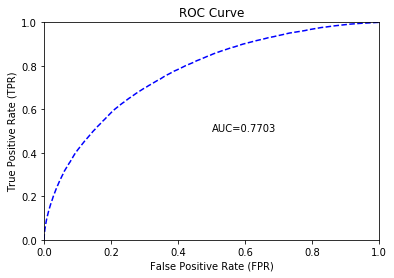

X-Val


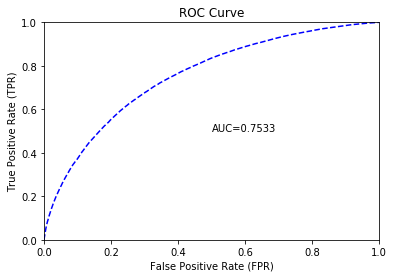

In [32]:
print("Training Data")
gbm_model.model_performance(train = True).plot()
print("X-Val")
gbm_model.model_performance(xval=True).plot()

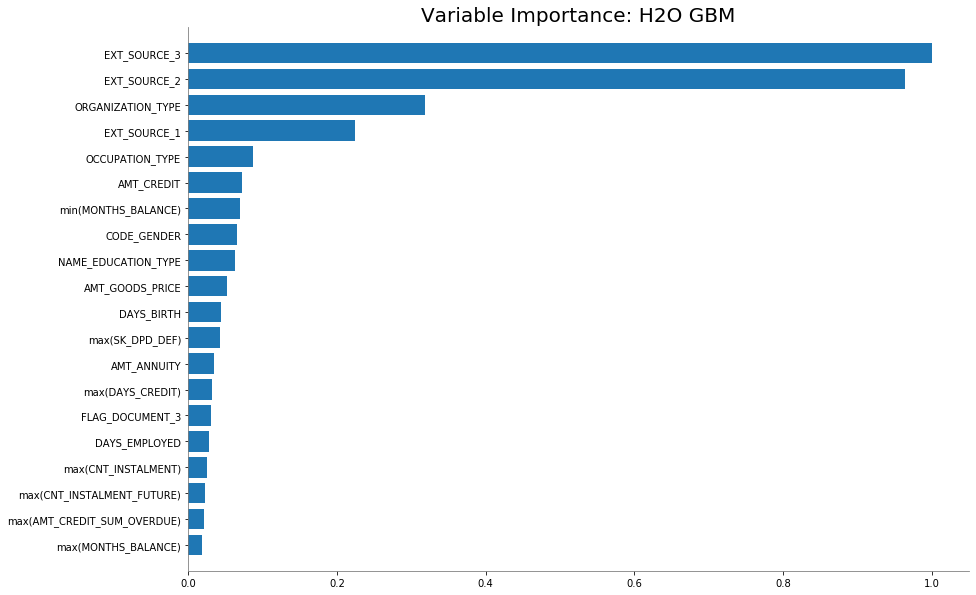

In [26]:
gbm_model.varimp_plot(20)

## Auto ML

In [27]:
aml.leaderboard

model_id,auc,logloss
GLM_grid_0_AutoML_20200410_085008_model_0,0.751253,0.248761
StackedEnsemble_AllModels_0_AutoML_20200410_085008,0.750832,0.25169
StackedEnsemble_BestOfFamily_0_AutoML_20200410_085008,0.750832,0.25169
DRF_0_AutoML_20200410_085008,0.719212,0.256384
XRT_0_AutoML_20200410_085008,0.7163,0.257949


Training Data


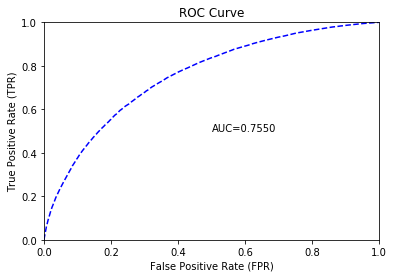

X-Val


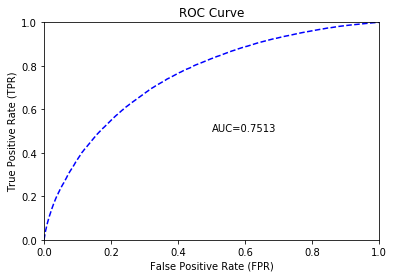

In [28]:
print("Training Data")
aml.leader.model_performance(train = True).plot()
print("X-Val")
aml.leader.model_performance(xval=True).plot()

Variable importance does not apply to GLM. Will use std_coef_plot() instead.


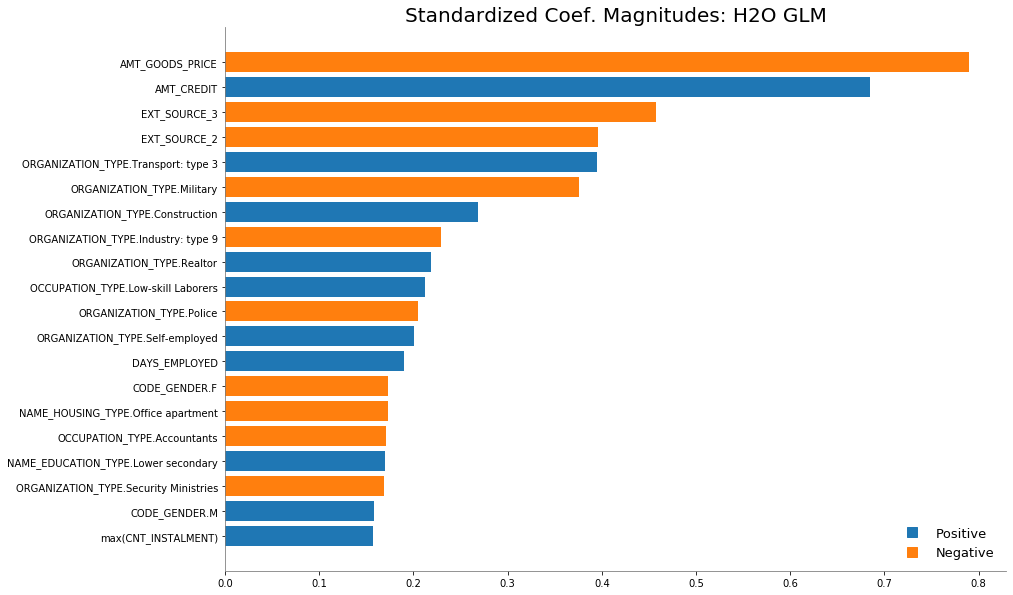

In [29]:
try:
    aml.leader.varimp_plot(20)
except:
    print('No variable importance')

# Deployment

Use the model for new data.

Auto ML

In [30]:
notFeatures = ['TARGET', 'SK_ID_CURR', 'SK_ID_CURR_MIN', 'SK_ID_CURR_MAX', 'SK_ID_CURR_BUR_MIN', 'SK_ID_CURR_BUR_MAX']
for notFeature in notFeatures:
    if notFeature in median_dict:
        del median_dict[notFeature]
sparkApplicationDataTest = sparkApplicationDataTest.na.fill(median_dict)
sparkApplicationDataTest.write\
        .format("com.databricks.spark.csv")\
        .option("header", "true")\
        .mode("overwrite")\
        .save('Data/preparedTest.csv')
df_test = h2o.import_file('Data/preparedTest.csv')
pred = aml.leader.predict(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [34]:
pred['SK_ID_CURR'] = df_test['SK_ID_CURR']
predFrame = pred.as_data_frame()
predFrame.to_csv('Data/pred.csv', index=False) 

Gradient Boosting

In [35]:
pred2 = gbm_model.predict(df_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [36]:
pred2['SK_ID_CURR'] = df_test['SK_ID_CURR']
predFrame2 = pred2.as_data_frame()
predFrame2.to_csv('Data/pred2.csv', index=False)

In [ ]:
spark.stop() #closing the spark session

## Kaggle Result
![CRISP-DM](Data/result.png)